In [193]:
import time
from tqdm import tqdm
import random
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options

In [220]:
final_df = pd.DataFrame({"Year":[],
             "Name":[],
             "Price":[],
             "Km":[],
             "Fuel":[]})

In [258]:
main_url = 'https://www.carwale.com/used/cars-for-sale/#'

In [171]:
url_list = []
for i in range(1,621):
    url_list.append(main_url+'city='+str(i)+'&pc='+str(i)+'&pn=1')

In [172]:
len(url_list)

620

In [219]:
def get_cars_data(url):   ## creating a function to complete the process from scraping, cleaning to creating the dataframe      
    ## opening a chrome window in webdriver inside the function without displaying the opened page
    
    chrome_options = Options()
    chrome_options.headless = True
    driver = webdriver.Chrome('./chromedriver',chrome_options=chrome_options)
    
    #_________________________________________________________________________
    
    ## opening the url
    driver.get(url)
    
    #_________________________________________________________________________
    
    ## scrolling upto a miximum range
    driver.execute_script("window.scrollTo(0, window.scrollY + 200)")
    
    #_________________________________________________________________________
    
    ## Parsing the webpage
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    
    #_________________________________________________________________________
    
    ## Putting all the available data in blank lists
    year, name, price, km, fuel = [], [], [], [], []
    for i in soup.find_all("div",{"class":"stock-detail"}):
        #year
        year.append(i.find("span",{"class":"slYear card-detail-block__title-text-with-year"}).text)
        #name
        name.append(i.find("span",{"class":"spancarname card-detail-block__title-text-with-year"}).text)
        #price
        price.append(i.find("span",{"class":"rupee-lac slprice"}).text) 
        #km
        km.append(i.find("tr",{"class":"otherDetails card-detail__vehicle-information card-detail__vehicle-data card-detail-vehicle-info"}).find("span",{"class":"slkms vehicle-data__item"}).text)
        #fuel
        fuel.append(i.find("tr",{"class":"otherDetails card-detail__vehicle-information card-detail__vehicle-data card-detail-vehicle-info"}).find("span",{"class":"fuel vehicle-data__item"}).text)
    #_______________________________________________________________________________
    
    ## Creating the dataframe
    df = pd.DataFrame({"Year":year,
             "Name":name,
             "Price":price,
             "Km":km,
             "Fuel":fuel})
    #_______________________________________________________________________________
    
    ## Cleaning the required columns
    def clean_price(x):
        if "Lakh" in x:
            x = x.replace("₹", "").replace("Lakh", "").replace(" ", "").replace(',','')
            x = float(x) * 100000
        elif "Crore" in x:
            x = x.replace("₹", "").replace("Crore", "").replace(" ", "").replace(',','')
            x = float(x) * 10000000
        return x
    df['Price'] = df['Price'].apply(clean_price)
    
    def clean_km(x):
        x = x.replace(',','').replace('km', '')
        return float(x)
    df['Km'] = df['Km'].apply(clean_km)
    
    #____________________________________________________________________________
    return df

In [221]:
for url in tqdm(url_list):
    time.sleep(random.randint(0,5))
    try:
        df = get_cars_data(url)
        final_df = final_df.append(df)
    except Exception as e:
        print(e)
        pass

  0%|                                                                                          | 0/620 [00:00<?, ?it/s]<ipython-input-219-c224821f314c>:6: DeprecationWarning: use options instead of chrome_options
  driver = webdriver.Chrome('./chromedriver',chrome_options=chrome_options)
100%|██████████████████████████████████████████████████████████████████████████████| 620/620 [1:45:52<00:00, 10.25s/it]


In [222]:
final_df.shape

(12172, 5)

In [223]:
final_df.head()

,Year,Name,Price,Km,Fuel
0,2012,Hyundai Verna Fluidic 1.6 CRDi SX Opt AT,475000,44211.0,Diesel
1,2010,Toyota Innova 2.5 V 7 STR,599000,189362.0,Diesel
2,2019,Tata Nexon XMA Diesel,925000,13797.0,Diesel
3,2016,BMW 1 Series 118d Hatchback,2.8e+06,44155.0,Diesel
4,2011,Mercedes-Benz S-Class 350 CDI L,2.5e+06,51086.0,Diesel


In [224]:
final_df.to_csv("Car_Sales_Price_Data.csv",index=False)

In [259]:
final_df = pd.read_csv("Car_Sales_Price_Data.csv")

In [260]:
final_df["Year"] = final_df["Year"].astype(float)
final_df["Km"] = final_df["Km"].astype(float)
final_df["Price"] = final_df["Price"].apply(lambda x: str(x).replace("₹","").replace(",","").replace(" ",""))
final_df["Price"] = final_df["Price"].astype(float)

In [261]:
final_df["Age"] = 2021 - final_df["Year"]

In [262]:
final_df.corr()[["Price"]]

,Price
Year,0.180399
Price,1.000000
Km,-0.136245
Age,-0.180399


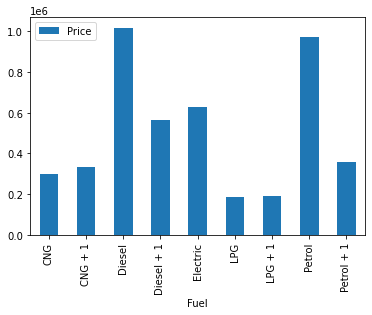

In [263]:
final_df[final_df["Fuel"] != "Hybrid"].groupby(["Fuel"]).mean()[["Price"]].plot.bar()

In [264]:
final_df["Fuel"].value_counts()

Diesel        4652
Petrol        3863
Petrol + 1    1829
Diesel + 1    1647
CNG + 1         84
LPG + 1         57
CNG             19
LPG             15
Electric         3
Hybrid           3
Name: Fuel, dtype: int64

In [257]:
final_df[final_df["Fuel"] == "Hybrid"]

,Year,Name,Price,Km,Fuel,Brand,Age
2852,2019.0,MG Hector Sharp Hybrid 1.5 Petrol [2019-2020],1750000.0,30000.0,Hybrid,MG,2.0
4772,2020.0,Toyota Vellfire Hybrid,9000000.0,26937.0,Hybrid,Toyota,1.0
8391,2020.0,Toyota Vellfire Hybrid,9000000.0,26937.0,Hybrid,Toyota,1.0


In [265]:
final_df["Brand"] = final_df["Name"].apply(lambda x: x.split(" ")[0])

In [266]:
final_df.head()

,Year,Name,Price,Km,Fuel,Age,Brand
0,2012.0,Hyundai Verna Fluidic 1.6 CRDi SX Opt AT,475000.0,44211.0,Diesel,9.0,Hyundai
1,2010.0,Toyota Innova 2.5 V 7 STR,599000.0,189362.0,Diesel,11.0,Toyota
2,2019.0,Tata Nexon XMA Diesel,925000.0,13797.0,Diesel,2.0,Tata
3,2016.0,BMW 1 Series 118d Hatchback,2800000.0,44155.0,Diesel,5.0,BMW
4,2011.0,Mercedes-Benz S-Class 350 CDI L,2500000.0,51086.0,Diesel,10.0,Mercedes-Benz


In [267]:
final_df["Brand"].value_counts()

Maruti              3963
Hyundai             1984
Mahindra            1034
Tata                 973
Toyota               650
Honda                594
Ford                 551
Renault              471
Volkswagen           284
Mercedes-Benz        282
Chevrolet            282
BMW                  211
Skoda                177
Audi                 153
Nissan               150
Datsun                69
Land                  64
Fiat                  59
Porsche               31
Jeep                  27
Jaguar                27
Volvo                 23
Kia                   22
MG                    18
Bentley               11
Hindustan             10
Mahindra-Renault      10
Mitsubishi             9
Rolls-Royce            8
MINI                   7
Lamborghini            4
Isuzu                  4
Force                  4
Ssangyong              3
Opel                   3
Name: Brand, dtype: int64

In [294]:
len(final_df["Brand"].unique())

35

In [269]:
final_df[final_df["Brand"] == "Tata"].head()

,Year,Name,Price,Km,Fuel,Age,Brand
2,2019.0,Tata Nexon XMA Diesel,925000.0,13797.0,Diesel,2.0,Tata
136,2011.0,Tata Aria Pure 4x2,480000.0,47078.0,Diesel,10.0,Tata
144,2018.0,Tata Indigo eCS GLS,399000.0,70000.0,Petrol + 1,3.0,Tata
149,2017.0,Tata Hexa XM 4x2 7 STR,1115000.0,30000.0,Diesel + 1,4.0,Tata
151,2010.0,Tata Indigo CS GLS,120000.0,37000.0,Petrol + 1,11.0,Tata


In [272]:
" ".join("Tata Hexa XM 4x2 7 STR".split(" ")[1:])

'Hexa XM 4x2 7 STR'

In [273]:
final_df["Variant"] = final_df["Name"].apply(lambda x: " ".join(x.split(" ")[1:]))

In [281]:
test_df = final_df[final_df["Brand"] == "Mercedes-Benz"]["Variant"].value_counts().to_frame().reset_index()

In [290]:
test_df[test_df["Variant"] == 1]["index"].values

array(['GLA 200 Sport', 'S-Class 350 CDI Long Blue-Efficiency',
       'S-Class 500L', 'C-Class 250 Avantgarde', 'M-Class 320',
       'C-Class 250 CDI Avantagarde', 'GLA 200 CDI Style',
       'E-Class E250 Elegance', 'E-Class E 250 CDI Edition E',
       'E-Class E 250 CDI Avantgarde', 'B-Class B180 Sports',
       'C-Class 250 CDI', 'C-Class 250 CDI Avantgarde',
       'C-Class C 43 AMG', 'G-Class 55 AMG',
       'C-Class C 200 Progressive [2018-2020]', 'C-Class 200 K AT',
       'E-Class E250 CDI Launch Edition', 'CLS 350 BlueEFFICIENCY',
       'GLE Coupe 53 AMG 4Matic Plus', '200 Diesel',
       'GLC 220d 4MATIC Progressive', 'CLA 200 CDI Sport (CBU)',
       'S-Class 320 CDI', 'B-Class B180', 'GLC Coupe 43 AMG [2017-2019]'],
      dtype=object)

In [286]:
test_df[test_df["Variant"]==1]["index"].values

array(['GLA 200 Sport', 'S-Class 350 CDI Long Blue-Efficiency',
       'S-Class 500L', 'C-Class 250 Avantgarde', 'M-Class 320',
       'C-Class 250 CDI Avantagarde', 'GLA 200 CDI Style',
       'E-Class E250 Elegance', 'E-Class E 250 CDI Edition E',
       'E-Class E 250 CDI Avantgarde', 'B-Class B180 Sports',
       'C-Class 250 CDI', 'C-Class 250 CDI Avantgarde',
       'C-Class C 43 AMG', 'G-Class 55 AMG',
       'C-Class C 200 Progressive [2018-2020]', 'C-Class 200 K AT',
       'E-Class E250 CDI Launch Edition', 'CLS 350 BlueEFFICIENCY',
       'GLE Coupe 53 AMG 4Matic Plus', '200 Diesel',
       'GLC 220d 4MATIC Progressive', 'CLA 200 CDI Sport (CBU)',
       'S-Class 320 CDI', 'B-Class B180', 'GLC Coupe 43 AMG [2017-2019]'],
      dtype=object)

In [293]:
final_df[final_df["Variant"].isin(test_df[test_df["Variant"]==1]["index"].values)]

,Year,Name,Price,Km,Fuel,Age,Brand,Variant
1845,2018.0,Mercedes-Benz GLA 200 Sport,2675000.0,16000.0,Petrol,3.0,Mercedes-Benz,GLA 200 Sport
2408,2010.0,Mercedes-Benz C-Class 250 Avantgarde,685000.0,70127.0,Petrol,11.0,Mercedes-Benz,C-Class 250 Avantgarde
3154,2014.0,Mercedes-Benz B-Class B180 Sports,1050000.0,73000.0,Petrol + 1,7.0,Mercedes-Benz,B-Class B180 Sports
3843,2009.0,Mercedes-Benz M-Class 320,1250000.0,76500.0,Petrol,12.0,Mercedes-Benz,M-Class 320
4196,2011.0,Mercedes-Benz C-Class 250 CDI,1250000.0,97000.0,Diesel,10.0,Mercedes-Benz,C-Class 250 CDI
4198,2011.0,Mercedes-Benz G-Class 55 AMG,6800000.0,56941.0,Petrol,10.0,Mercedes-Benz,G-Class 55 AMG
4206,2011.0,Mercedes-Benz CLS 350 BlueEFFICIENCY,1950000.0,56000.0,Petrol,10.0,Mercedes-Benz,CLS 350 BlueEFFICIENCY
4229,2017.0,Mercedes-Benz GLA 200 CDI Style,2190000.0,32145.0,Diesel,4.0,Mercedes-Benz,GLA 200 CDI Style
4251,2013.0,Mercedes-Benz B-Class B180,1250000.0,92270.0,Petrol,8.0,Mercedes-Benz,B-Class B180
4636,2008.0,Mercedes-Benz S-Class 320 CDI,1200000.0,85000.0,Diesel + 1,13.0,Mercedes-Benz,S-Class 320 CDI


In [305]:
independent_variables = final_df[["Km","Fuel","Age","Brand"]]
dependent_variable = final_df[["Price"]]

In [308]:
independent_variables.dtypes

Km       float64
Fuel      object
Age      float64
Brand     object
dtype: object

In [310]:
import numpy as np
np.where(independent_variables.dtypes != np.float)[0]

array([1, 3], dtype=int64)

In [311]:
categorical_features_indices = np.where(independent_variables.dtypes != np.float)[0]

In [296]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [297]:
from catboost import CatBoostRegressor

In [328]:
brand_df = pd.get_dummies(independent_variables[["Brand"]])

In [329]:
fuel_df = pd.get_dummies(independent_variables[["Fuel"]])

In [330]:
merged_df = pd.merge(independent_variables[["Km","Age"]],brand_df,left_index=True, right_index=True)

In [331]:
merged_df_final = pd.merge(merged_df,fuel_df,left_index=True, right_index=True)

In [333]:
merged_df_final.shape

(12172, 47)

In [334]:
X_train, X_test, y_train, y_test = train_test_split(merged_df_final, dependent_variable, train_size=0.7, random_state=1)

In [364]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xg
from sklearn.metrics import median_absolute_error, explained_variance_score

In [366]:
model_gradboost = GradientBoostingRegressor()
model_LR = LinearRegression()
model_RF = RandomForestRegressor()
model_catboost = CatBoostRegressor()
model_xg = xg.XGBRegressor()

In [359]:
def get_regression_scores(X_train, X_test, y_train, y_test, model):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    rmse = (np.sqrt(mean_squared_error(y_test, pred)))
    r2 = r2_score(y_test, pred)
    med_err = median_absolute_error(y_test, pred)
    ex_v_sc = explained_variance_score(y_test, pred)
    
    print("Testing performance")
    print("RMSE: ",rmse)
    print("R2: ",r2)
    print("Median Absolute Error: ",med_err)
    print("Expalined variance score: ",ex_v_sc)

In [360]:
get_regression_scores(X_train, X_test, y_train, y_test, model_gradboost)

C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Testing performance
RMSE:  723035.5007280561
R2:  0.9168309601555713
Median Absolute Error:  135678.5950189166
Expalined variance score:  0.9168309914484165


In [361]:
get_regression_scores(X_train, X_test, y_train, y_test, model_LR)

Testing performance
RMSE:  1113659.6589932467
R2:  0.8026907612299244
Median Absolute Error:  159349.0564165502
Expalined variance score:  0.8028001643719711


In [362]:
get_regression_scores(X_train, X_test, y_train, y_test, model_RF)

<ipython-input-359-c3669bb455e8>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Testing performance
RMSE:  620307.3457811447
R2:  0.9387852199841018
Median Absolute Error:  56536.66666666666
Expalined variance score:  0.9387854539228617


In [363]:
get_regression_scores(X_train, X_test, y_train, y_test, model_catboost)

Learning rate set to 0.05715
0:	learn: 2012635.6677010	total: 6.46ms	remaining: 6.46s
1:	learn: 1953568.3205562	total: 10.5ms	remaining: 5.22s
2:	learn: 1902605.6637059	total: 13.7ms	remaining: 4.54s
3:	learn: 1853349.2278645	total: 16.7ms	remaining: 4.16s
4:	learn: 1802441.3097699	total: 19.7ms	remaining: 3.91s
5:	learn: 1757283.0509836	total: 22.7ms	remaining: 3.76s
6:	learn: 1712847.2313228	total: 25.7ms	remaining: 3.65s
7:	learn: 1670008.1105461	total: 28.4ms	remaining: 3.52s
8:	learn: 1631979.7349599	total: 30.7ms	remaining: 3.38s
9:	learn: 1597705.9737831	total: 32.8ms	remaining: 3.25s
10:	learn: 1560842.1210154	total: 35ms	remaining: 3.15s
11:	learn: 1526869.6583234	total: 37.3ms	remaining: 3.07s
12:	learn: 1492245.2421763	total: 39.4ms	remaining: 2.99s
13:	learn: 1459139.0366475	total: 41.4ms	remaining: 2.92s
14:	learn: 1430220.7710080	total: 43.6ms	remaining: 2.87s
15:	learn: 1402589.7095027	total: 45.7ms	remaining: 2.81s
16:	learn: 1376359.6547327	total: 48ms	remaining: 2.77s

## Catboost regressor is providing the best result hence selecting this as the decisive model